In [2]:
from keras.models import Model, Sequential
from keras.layers import Activation, Dense, BatchNormalization, concatenate, Dropout, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Input, Reshape
from keras.callbacks import EarlyStopping
from keras.layers import SpatialDropout2D
from keras import backend as K
from keras.optimizers import Adam
import tensorflow as tf
import numpy as np
import pandas as pd
import glob
import PIL
from PIL import Image
import matplotlib.pyplot as plt
import cv2
%matplotlib inline

from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from warnings import filterwarnings

filterwarnings('ignore')
np.random.seed(101)

In [3]:
import re
numbers = re.compile(r'(\d+)')
def numericalSort(value):
    parts = numbers.split(value)
    parts[1::2] = map(int, parts[1::2])
    return parts

In [4]:
def load_images(filelist, resize_dim):
    images = []
    for fname in filelist:
        img = Image.open(fname)
        img = img.resize(resize_dim)  
        img = np.array(img)
        images.append(img)
    return np.array(images)

filelist_trainx = sorted(glob.glob('trainx/*.bmp'), key=numericalSort)
filelist_trainy = sorted(glob.glob('trainy/*.bmp'), key=numericalSort)

X_train = load_images(filelist_trainx, (224, 224))  
Y_train = load_images(filelist_trainy, (224, 224))  

In [5]:
x_train, x_test, y_train, y_test = train_test_split(X_train, Y_train, test_size = 0.25, random_state = 101)

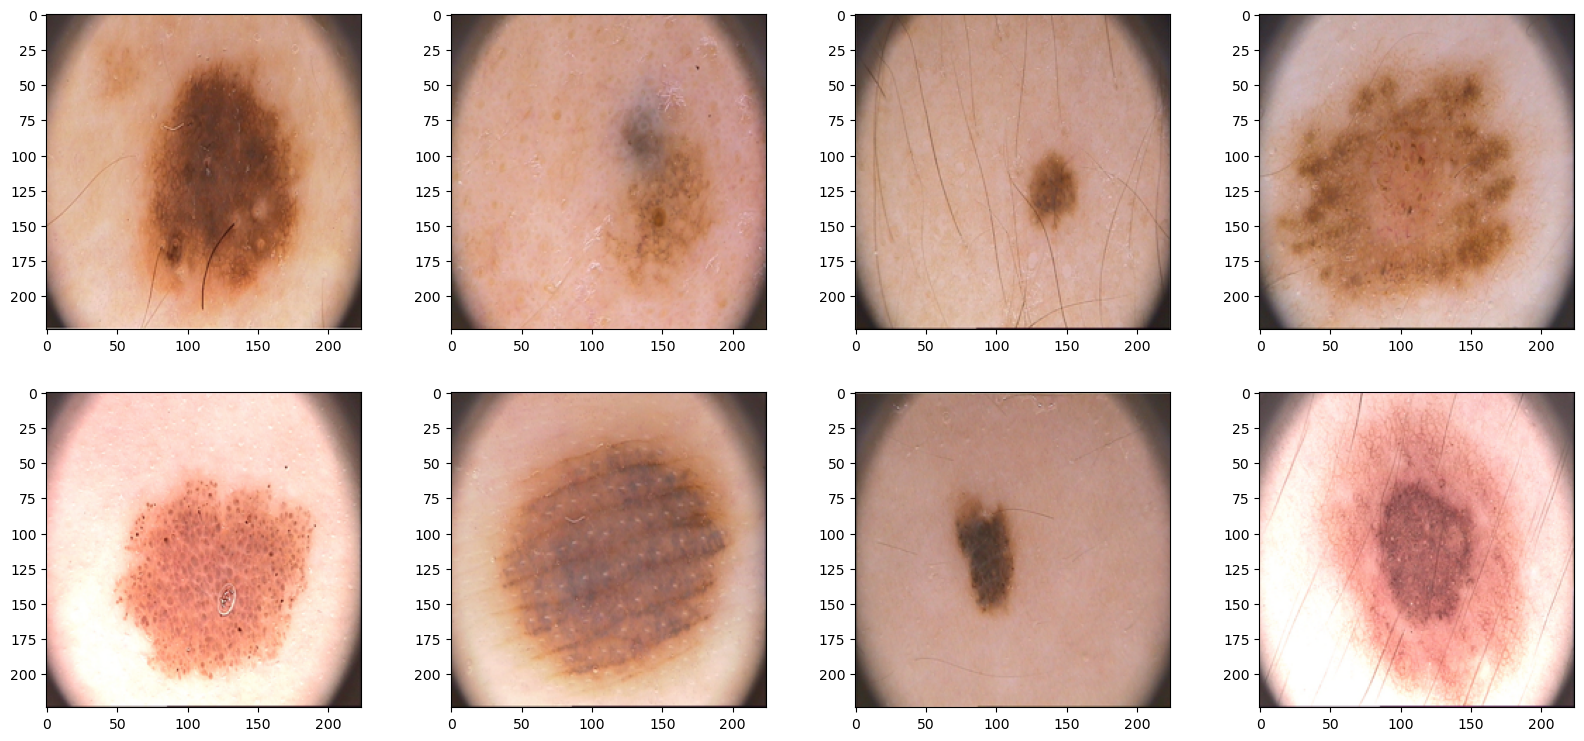

In [6]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(X_train[0])
plt.subplot(2,4,2)
plt.imshow(X_train[3])
plt.subplot(2,4,3)
plt.imshow(X_train[54])
plt.subplot(2,4,4)
plt.imshow(X_train[77])
plt.subplot(2,4,5)
plt.imshow(X_train[100])
plt.subplot(2,4,6)
plt.imshow(X_train[125])
plt.subplot(2,4,7)
plt.imshow(X_train[130])
plt.subplot(2,4,8)
plt.imshow(X_train[149])
plt.show()

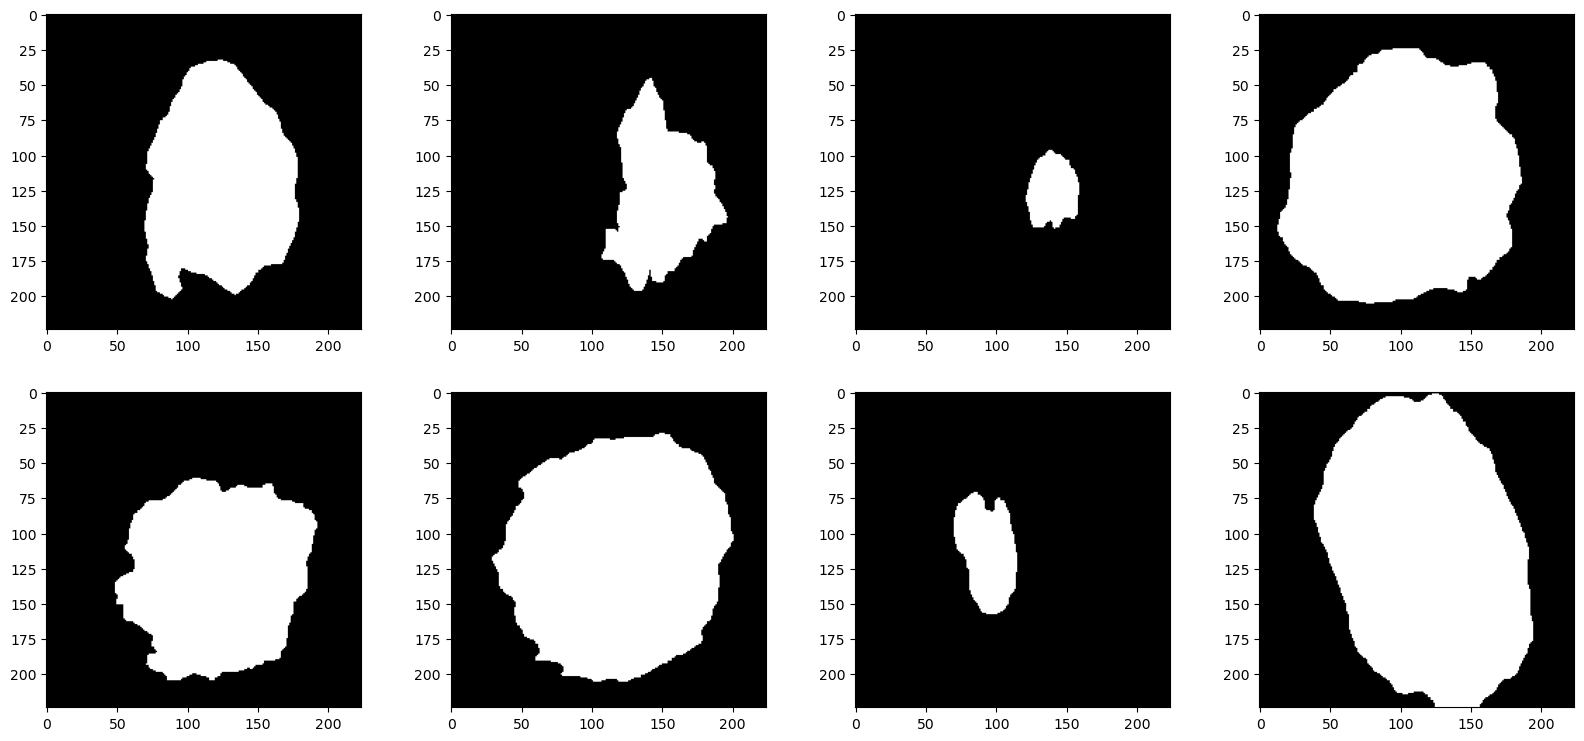

In [7]:
plt.figure(figsize=(20,9))
plt.subplot(2,4,1)
plt.imshow(Y_train[0], cmap = plt.cm.binary_r)
plt.subplot(2,4,2)
plt.imshow(Y_train[3], cmap = plt.cm.binary_r)
plt.subplot(2,4,3)
plt.imshow(Y_train[54], cmap = plt.cm.binary_r)
plt.subplot(2,4,4)
plt.imshow(Y_train[77], cmap = plt.cm.binary_r)
plt.subplot(2,4,5)
plt.imshow(Y_train[100], cmap = plt.cm.binary_r)
plt.subplot(2,4,6)
plt.imshow(Y_train[125], cmap = plt.cm.binary_r)
plt.subplot(2,4,7)
plt.imshow(Y_train[130], cmap = plt.cm.binary_r)
plt.subplot(2,4,8)
plt.imshow(Y_train[149], cmap = plt.cm.binary_r)
plt.show()

In [8]:
def jaccard_distance(y_true, y_pred, smooth=100):
    y_true = K.cast(y_true, dtype='float32')
    y_pred = K.cast(y_pred, dtype='float32')
    
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis=-1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return (1 - jac) * smooth


In [9]:
def iou(y_true, y_pred, smooth = 100):
    intersection = K.sum(K.abs(y_true * y_pred), axis=-1)
    sum_ = K.sum(K.square(y_true), axis = -1) + K.sum(K.square(y_pred), axis=-1)
    jac = (intersection + smooth) / (sum_ - intersection + smooth)
    return jac

In [10]:
def dice_coe(y_true, y_pred, smooth = 100):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)

In [11]:
def precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

In [12]:
def recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

In [13]:
def accuracy(y_true, y_pred):
    return K.mean(K.equal(y_true, K.round(y_pred)))

In [14]:
def random_rotation(x_image, y_image):
    rows_x,cols_x, chl_x = x_image.shape
    rows_y,cols_y = y_image.shape
    rand_num = np.random.randint(-40,40)
    M1 = cv2.getRotationMatrix2D((cols_x/2,rows_x/2),rand_num,1)
    M2 = cv2.getRotationMatrix2D((cols_y/2,rows_y/2),rand_num,1)
    x_image = cv2.warpAffine(x_image,M1,(cols_x,rows_x))
    y_image = cv2.warpAffine(y_image.astype('float32'),M2,(cols_y,rows_y))
    return x_image, y_image.astype('int')

def horizontal_flip(x_image, y_image):
    x_image = cv2.flip(x_image, 1)
    y_image = cv2.flip(y_image.astype('float32'), 1)
    return x_image, y_image.astype('int')

In [15]:
def img_augmentation(x_train, y_train):
    x_rotat = []
    y_rotat = []
    x_flip = []
    y_flip = []
    for idx in range(len(x_train)):
        x,y = random_rotation(x_train[idx], y_train[idx])
        x_rotat.append(x)
        y_rotat.append(y)
        x,y = horizontal_flip(x_train[idx], y_train[idx])
        x_flip.append(x)
        y_flip.append(y)
    return np.array(x_rotat), np.array(y_rotat), np.array(x_flip), np.array(y_flip)

In [16]:
x_rotated, y_rotated, x_flipped, y_flipped = img_augmentation(x_train, y_train)

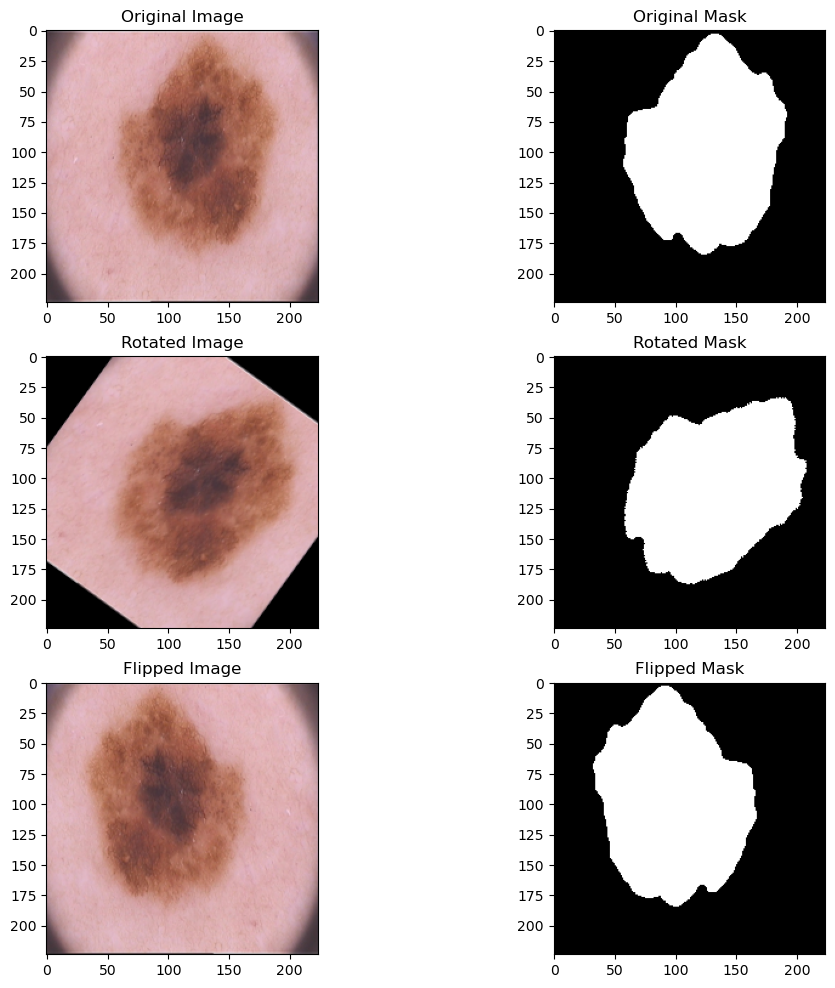

In [17]:
img_num = 7
plt.figure(figsize=(12,12))
plt.subplot(3,2,1)
plt.imshow(x_train[img_num])
plt.title('Original Image')
plt.subplot(3,2,2)
plt.imshow(y_train[img_num], plt.cm.binary_r)
plt.title('Original Mask')
plt.subplot(3,2,3)
plt.imshow(x_rotated[img_num])
plt.title('Rotated Image')
plt.subplot(3,2,4)
plt.imshow(y_rotated[img_num], plt.cm.binary_r)
plt.title('Rotated Mask')
plt.subplot(3,2,5)
plt.imshow(x_flipped[img_num])
plt.title('Flipped Image')
plt.subplot(3,2,6)
plt.imshow(y_flipped[img_num], plt.cm.binary_r)
plt.title('Flipped Mask')
plt.show()

In [18]:
x_train_full = np.concatenate([x_train, x_rotated, x_flipped])
y_train_full = np.concatenate([y_train, y_rotated, y_flipped])

In [19]:
x_train, x_val, y_train, y_val = train_test_split(x_train_full, y_train_full, test_size = 0.20, random_state = 101)

In [22]:
print("Length of the Training Set   : {}".format(len(x_train)))
print("Length of the Test Set       : {}".format(len(x_test)))
print("Length of the Validation Set : {}".format(len(x_val)))

Length of the Training Set   : 360
Length of the Test Set       : 50
Length of the Validation Set : 90


In [23]:
INPUT_CHANNELS = 3
OUTPUT_MASK_CHANNELS = 1

In [24]:
def double_conv_layer(x, size, dropout=0.40, batch_norm=True):
    if K.image_data_format() == 'channels_first':
        axis = 1
    else:
        axis = 3

    conv = Conv2D(size, (3, 3), padding='same')(x)
    if batch_norm:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)

    conv = Conv2D(size, (3, 3), padding='same')(conv)
    if batch_norm:
        conv = BatchNormalization(axis=axis)(conv)
    conv = Activation('relu')(conv)

    if dropout > 0:
        conv = SpatialDropout2D(dropout)(conv)

    return conv


def UNET_224(epochs_num, savename):
    dropout_val=0.50
    if K.image_data_format() == 'channels_first':
        inputs = Input((INPUT_CHANNELS, 224, 224))
        axis = 1
    else:
        inputs = Input((224, 224, INPUT_CHANNELS))
        axis = 3
    filters = 32

    conv_224 = double_conv_layer(inputs, filters)
    pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

    conv_112 = double_conv_layer(pool_112, 2*filters)
    pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

    conv_56 = double_conv_layer(pool_56, 4*filters)
    pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

    conv_28 = double_conv_layer(pool_28, 8*filters)
    pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

    conv_14 = double_conv_layer(pool_14, 16*filters)
    pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

    conv_7 = double_conv_layer(pool_7, 32*filters)

    up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
    up_conv_14 = double_conv_layer(up_14, 16*filters)

    up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
    up_conv_28 = double_conv_layer(up_28, 8*filters)

    up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
    up_conv_56 = double_conv_layer(up_56, 4*filters)

    up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
    up_conv_112 = double_conv_layer(up_112, 2*filters)

    up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
    up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

    conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
    conv_final = Activation('sigmoid')(conv_final)
    pred = Reshape((224,224))(conv_final)
    model = Model(inputs, pred, name="UNET_224")
    model.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])
    model.summary()
    hist = model.fit(x_train, y_train, epochs= epochs_num, batch_size= 16,validation_data=(x_val, y_val), verbose=1)
    model.save(savename)
    return model, hist

In [25]:
model, hist = UNET_224(1, 'unet_1_epoch.h5')

Model: "UNET_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 224, 224, 32)         896       ['input_1[0][0]']             
                                                                                                  
 batch_normalization (Batch  (None, 224, 224, 32)         128       ['conv2d[0][0]']              
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 224, 224, 32)         0         ['batch_normalization[0

 activation_7 (Activation)   (None, 28, 28, 256)          0         ['batch_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 spatial_dropout2d_3 (Spati  (None, 28, 28, 256)          0         ['activation_7[0][0]']        
 alDropout2D)                                                                                     
                                                                                                  
 max_pooling2d_3 (MaxPoolin  (None, 14, 14, 256)          0         ['spatial_dropout2d_3[0][0]'] 
 g2D)                                                                                             
                                                                                                  
 conv2d_8 (Conv2D)           (None, 14, 14, 512)          1180160   ['max_pooling2d_3[0][0]']     
          

 batch_normalization_14 (Ba  (None, 28, 28, 256)          1024      ['conv2d_14[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_14 (Activation)  (None, 28, 28, 256)          0         ['batch_normalization_14[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_15 (Conv2D)          (None, 28, 28, 256)          590080    ['activation_14[0][0]']       
                                                                                                  
 batch_normalization_15 (Ba  (None, 28, 28, 256)          1024      ['conv2d_15[0][0]']           
 tchNormalization)                                                                                
          

 batch_normalization_21 (Ba  (None, 224, 224, 32)         128       ['conv2d_21[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_21 (Activation)  (None, 224, 224, 32)         0         ['batch_normalization_21[0][0]
                                                                    ']                            
                                                                                                  
 spatial_dropout2d_10 (Spat  (None, 224, 224, 32)         0         ['activation_21[0][0]']       
 ialDropout2D)                                                                                    
                                                                                                  
 conv2d_22 (Conv2D)          (None, 224, 224, 1)          33        ['spatial_dropout2d_10[0][0]']
          

In [26]:
dropout_val=0.50
if K.image_data_format() == 'channels_first':
    inputs = Input((INPUT_CHANNELS, 224, 224))
    axis = 1
else:
    inputs = Input((224, 224, INPUT_CHANNELS))
    axis = 3
filters = 32

conv_224 = double_conv_layer(inputs, filters)
pool_112 = MaxPooling2D(pool_size=(2, 2))(conv_224)

conv_112 = double_conv_layer(pool_112, 2*filters)
pool_56 = MaxPooling2D(pool_size=(2, 2))(conv_112)

conv_56 = double_conv_layer(pool_56, 4*filters)
pool_28 = MaxPooling2D(pool_size=(2, 2))(conv_56)

conv_28 = double_conv_layer(pool_28, 8*filters)
pool_14 = MaxPooling2D(pool_size=(2, 2))(conv_28)

conv_14 = double_conv_layer(pool_14, 16*filters)
pool_7 = MaxPooling2D(pool_size=(2, 2))(conv_14)

conv_7 = double_conv_layer(pool_7, 32*filters)

up_14 = concatenate([UpSampling2D(size=(2, 2))(conv_7), conv_14], axis=axis)
up_conv_14 = double_conv_layer(up_14, 16*filters)

up_28 = concatenate([UpSampling2D(size=(2, 2))(up_conv_14), conv_28], axis=axis)
up_conv_28 = double_conv_layer(up_28, 8*filters)

up_56 = concatenate([UpSampling2D(size=(2, 2))(up_conv_28), conv_56], axis=axis)
up_conv_56 = double_conv_layer(up_56, 4*filters)

up_112 = concatenate([UpSampling2D(size=(2, 2))(up_conv_56), conv_112], axis=axis)
up_conv_112 = double_conv_layer(up_112, 2*filters)

up_224 = concatenate([UpSampling2D(size=(2, 2))(up_conv_112), conv_224], axis=axis)
up_conv_224 = double_conv_layer(up_224, filters, dropout_val)

conv_final = Conv2D(OUTPUT_MASK_CHANNELS, (1, 1))(up_conv_224)
conv_final = Activation('sigmoid')(conv_final)
pred = Reshape((224,224))(conv_final)


In [27]:
model_0 = Model(inputs, pred, name="UNET_224")
model_0.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])


In [28]:
model_0.load_weights('unet_1_epoch.h5')

In [29]:

print('\n~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_0.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_0.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_0.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 1 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

20/20 [==============================] - 42s 2s/step - loss: 46.7582 - iou: 0.5324 - dice_coe: 0.4851 - precision: 0.3237 - recall: 1.0000 - accuracy: 0.3237
________________________
IOU:       |   53.24  |
Dice Coef: |   48.51  |
Precision: |   32.37  |
Recall:    |   100.00  |
Accuracy:  |   32.37  |
Loss:      |   4675.82  |
________________________

-------------On Test  Set--------------------------

3/3 [==============================] - 6s 2s/step - loss: 47.4621 - iou: 0.5254 - dice_coe: 0.4777 - precision: 0.3155 - recall: 1.0000 - accuracy: 0.3155
________________________
IOU:       |   52.54  |
Dice Coef: |   47.77  |
Precision: |   31.55  |
Recall:    |   100.00  |
Accuracy:  |   31.55  |
Loss:      |   4746.21  |
________________________

-------------On validation Set---------------------

5/5 [==============================] - 11s 2s/step - loss: 47.4919 - iou: 0.

In [30]:
model, hist = UNET_224(epochs_num= 100, savename= 'unet_100_epoch.h5')

Model: "UNET_224"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_3 (InputLayer)        [(None, 224, 224, 3)]        0         []                            
                                                                                                  
 conv2d_46 (Conv2D)          (None, 224, 224, 32)         896       ['input_3[0][0]']             
                                                                                                  
 batch_normalization_44 (Ba  (None, 224, 224, 32)         128       ['conv2d_46[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_46 (Activation)  (None, 224, 224, 32)         0         ['batch_normalization_4

                                                                                                  
 activation_53 (Activation)  (None, 28, 28, 256)          0         ['batch_normalization_51[0][0]
                                                                    ']                            
                                                                                                  
 spatial_dropout2d_25 (Spat  (None, 28, 28, 256)          0         ['activation_53[0][0]']       
 ialDropout2D)                                                                                    
                                                                                                  
 max_pooling2d_13 (MaxPooli  (None, 14, 14, 256)          0         ['spatial_dropout2d_25[0][0]']
 ng2D)                                                                                            
                                                                                                  
 conv2d_54

                                                                                                  
 batch_normalization_58 (Ba  (None, 28, 28, 256)          1024      ['conv2d_60[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_60 (Activation)  (None, 28, 28, 256)          0         ['batch_normalization_58[0][0]
                                                                    ']                            
                                                                                                  
 conv2d_61 (Conv2D)          (None, 28, 28, 256)          590080    ['activation_60[0][0]']       
                                                                                                  
 batch_normalization_59 (Ba  (None, 28, 28, 256)          1024      ['conv2d_61[0][0]']           
 tchNormal

                                                                                                  
 batch_normalization_65 (Ba  (None, 224, 224, 32)         128       ['conv2d_67[0][0]']           
 tchNormalization)                                                                                
                                                                                                  
 activation_67 (Activation)  (None, 224, 224, 32)         0         ['batch_normalization_65[0][0]
                                                                    ']                            
                                                                                                  
 spatial_dropout2d_32 (Spat  (None, 224, 224, 32)         0         ['activation_67[0][0]']       
 ialDropout2D)                                                                                    
                                                                                                  
 conv2d_68

Epoch 22/100
23/23 [==============================] - 182s 8s/step - loss: 6.6988 - iou: 0.9330 - dice_coe: 0.8381 - precision: 0.8927 - recall: 0.8709 - accuracy: 0.9224 - val_loss: 10.7440 - val_iou: 0.8926 - val_dice_coe: 0.8004 - val_precision: 0.7822 - val_recall: 0.8449 - val_accuracy: 0.8778
Epoch 23/100
23/23 [==============================] - 182s 8s/step - loss: 6.4902 - iou: 0.9351 - dice_coe: 0.8389 - precision: 0.9150 - recall: 0.8575 - accuracy: 0.9272 - val_loss: 7.5800 - val_iou: 0.9242 - val_dice_coe: 0.8542 - val_precision: 0.9192 - val_recall: 0.8169 - val_accuracy: 0.9187
Epoch 24/100
23/23 [==============================] - 182s 8s/step - loss: 6.3970 - iou: 0.9360 - dice_coe: 0.8475 - precision: 0.8991 - recall: 0.8856 - accuracy: 0.9274 - val_loss: 7.4508 - val_iou: 0.9255 - val_dice_coe: 0.8611 - val_precision: 0.9634 - val_recall: 0.7960 - val_accuracy: 0.9248
Epoch 25/100
23/23 [==============================] - 182s 8s/step - loss: 6.5223 - iou: 0.9348 - dice

23/23 [==============================] - 182s 8s/step - loss: 4.7517 - iou: 0.9525 - dice_coe: 0.8868 - precision: 0.9293 - recall: 0.9074 - accuracy: 0.9460 - val_loss: 4.6247 - val_iou: 0.9538 - val_dice_coe: 0.8971 - val_precision: 0.9237 - val_recall: 0.9097 - val_accuracy: 0.9471
Epoch 77/100
23/23 [==============================] - 182s 8s/step - loss: 5.0798 - iou: 0.9492 - dice_coe: 0.8762 - precision: 0.9141 - recall: 0.9054 - accuracy: 0.9420 - val_loss: 4.8910 - val_iou: 0.9511 - val_dice_coe: 0.8952 - val_precision: 0.9547 - val_recall: 0.8730 - val_accuracy: 0.9457
Epoch 78/100
23/23 [==============================] - 182s 8s/step - loss: 4.2849 - iou: 0.9572 - dice_coe: 0.8967 - precision: 0.9471 - recall: 0.9064 - accuracy: 0.9522 - val_loss: 5.1794 - val_iou: 0.9482 - val_dice_coe: 0.8899 - val_precision: 0.9590 - val_recall: 0.8515 - val_accuracy: 0.9404
Epoch 79/100
23/23 [==============================] - 182s 8s/step - loss: 4.1429 - iou: 0.9586 - dice_coe: 0.8999 -

In [31]:
model_1 = Model(inputs, pred, name="UNET_224")
model_1.compile(optimizer= Adam(lr = 0.003), loss= [jaccard_distance]
                  , metrics=[iou, dice_coe, precision, recall, accuracy])


In [32]:
model_1.load_weights('unet_100_epoch.h5')

![](http://)Testing the statistics after 100 epochs

In [33]:

print('\n~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~')
print('\n-------------On Train Set--------------------------\n')
res = model_1.evaluate(x_train, y_train, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On Test  Set--------------------------\n')
res = model_1.evaluate(x_test, y_test, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')
print('\n-------------On validation Set---------------------\n')
res = model_1.evaluate(x_val, y_val, batch_size= 18)
print('________________________')
print('IOU:       |   {:.2f}  |'.format(res[1]*100))
print('Dice Coef: |   {:.2f}  |'.format(res[2]*100))
print('Precision: |   {:.2f}  |'.format(res[3]*100))
print('Recall:    |   {:.2f}  |'.format(res[4]*100))
print('Accuracy:  |   {:.2f}  |'.format(res[5]*100))
print("Loss:      |   {:.2f}  |".format(res[0]*100))
print('________________________')


~~~~~~~~~~~~~~~Stats after 100 epoch~~~~~~~~~~~~~~~~~~~

-------------On Train Set--------------------------

20/20 [==============================] - 48s 2s/step - loss: 2.9123 - iou: 0.9709 - dice_coe: 0.9358 - precision: 0.9539 - recall: 0.9424 - accuracy: 0.9668
________________________
IOU:       |   97.09  |
Dice Coef: |   93.58  |
Precision: |   95.39  |
Recall:    |   94.24  |
Accuracy:  |   96.68  |
Loss:      |   291.23  |
________________________

-------------On Test  Set--------------------------

3/3 [==============================] - 6s 2s/step - loss: 3.5739 - iou: 0.9643 - dice_coe: 0.9255 - precision: 0.9344 - recall: 0.9409 - accuracy: 0.9614
________________________
IOU:       |   96.43  |
Dice Coef: |   92.55  |
Precision: |   93.44  |
Recall:    |   94.09  |
Accuracy:  |   96.14  |
Loss:      |   357.39  |
________________________

-------------On validation Set---------------------

5/5 [==============================] - 11s 2s/step - loss: 3.0404 - iou: 0.9696 

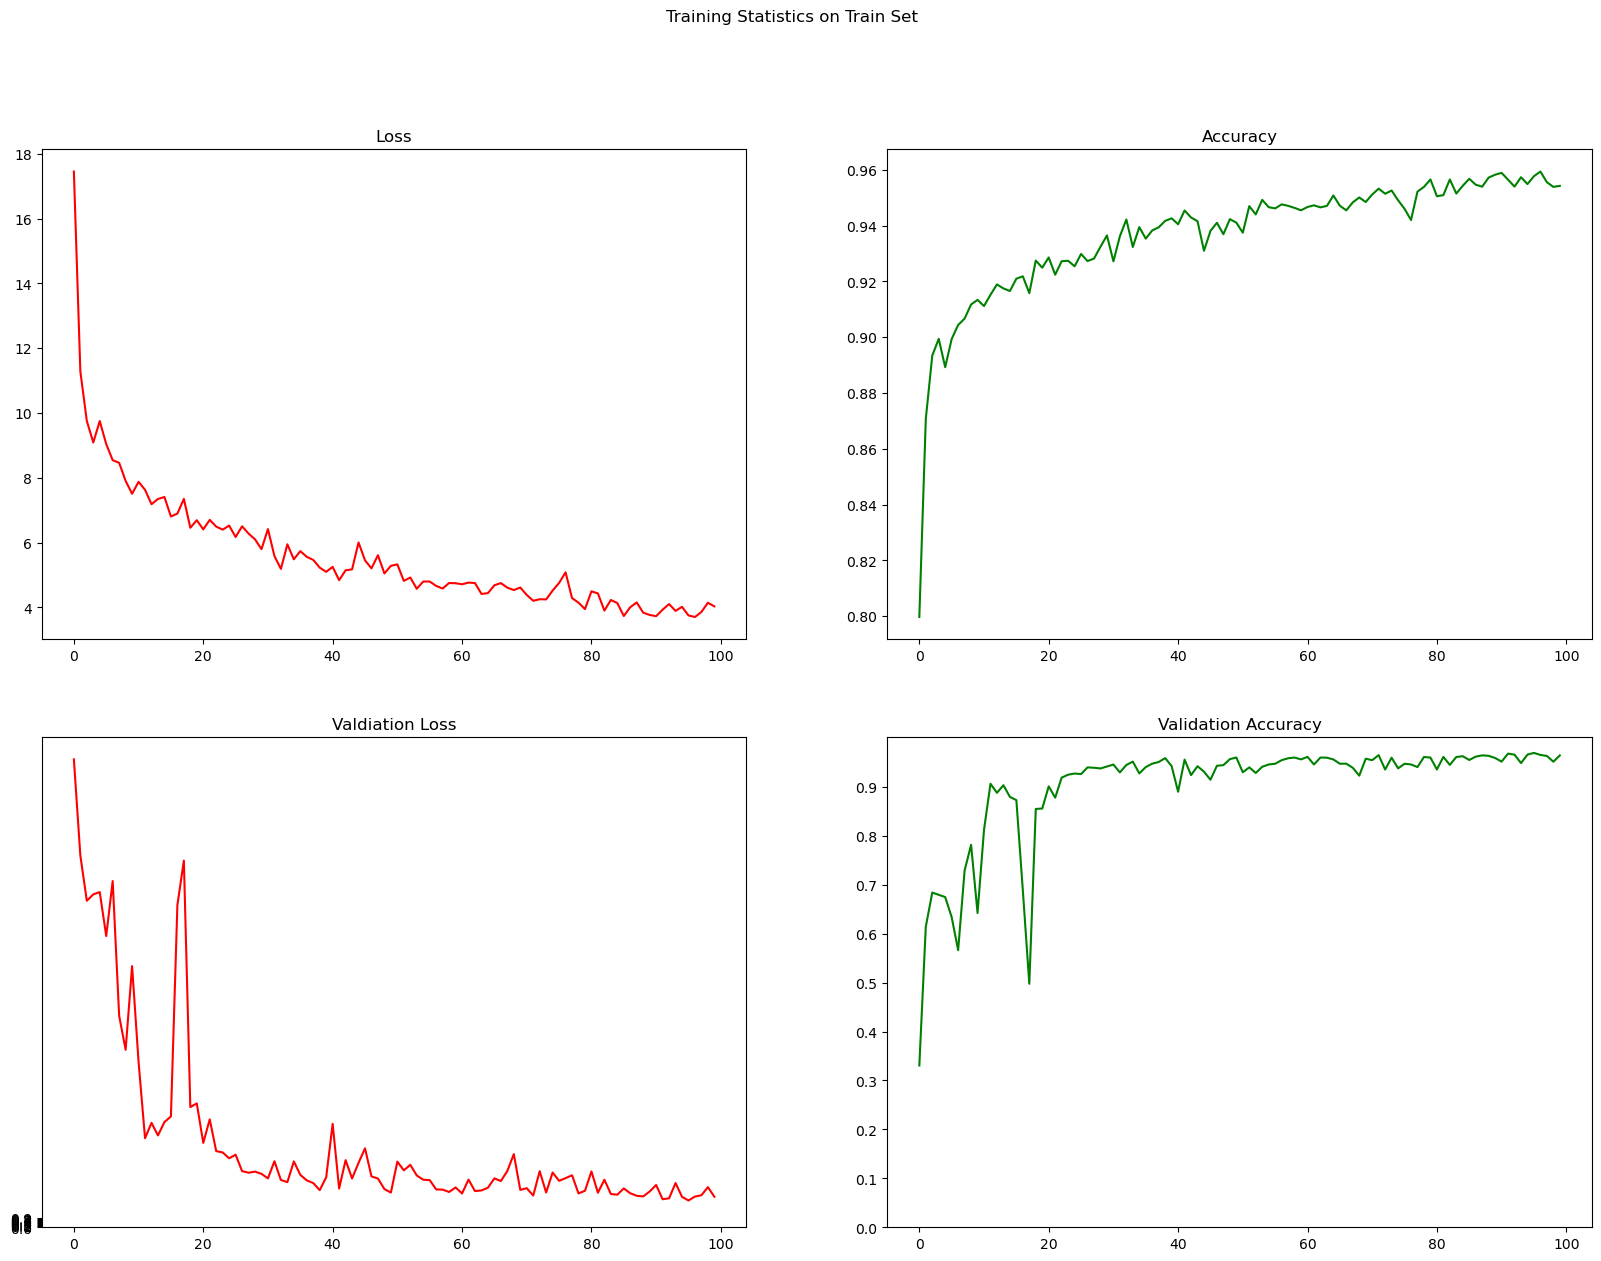

In [34]:
plt.figure(figsize=(20, 14))
plt.suptitle('Training Statistics on Train Set')
plt.subplot(2,2,1)
plt.plot(hist.history['loss'], 'red')
plt.title('Loss')
plt.subplot(2,2,2)
plt.plot(hist.history['accuracy'], 'green')
plt.title('Accuracy')
plt.subplot(2,2,3)
plt.plot(hist.history['val_loss'], 'red')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Valdiation Loss')
plt.subplot(2,2,4)
plt.plot(hist.history['val_accuracy'], 'green')
plt.yticks(list(np.arange(0.0, 1.0, 0.10)))
plt.title('Validation Accuracy')
plt.show()

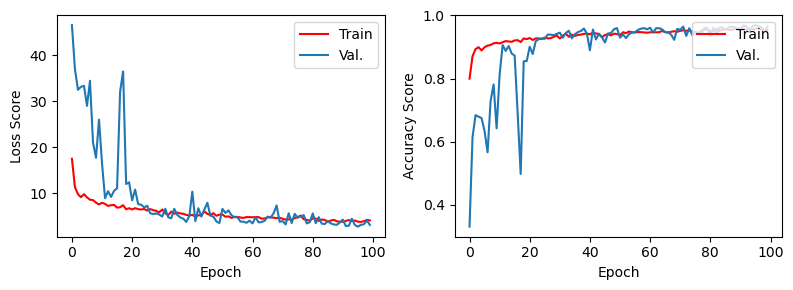

In [35]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(hist.history['loss'], color='r')
plt.plot(hist.history['val_loss'])
plt.ylabel('Loss Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val.'], loc='upper right')

plt.subplot(1,3,2)
plt.plot(hist.history['accuracy'], color='r')
plt.plot(hist.history['val_accuracy'])
plt.ylabel('Accuracy Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val.'], loc='upper right')

plt.tight_layout()

plt.show()

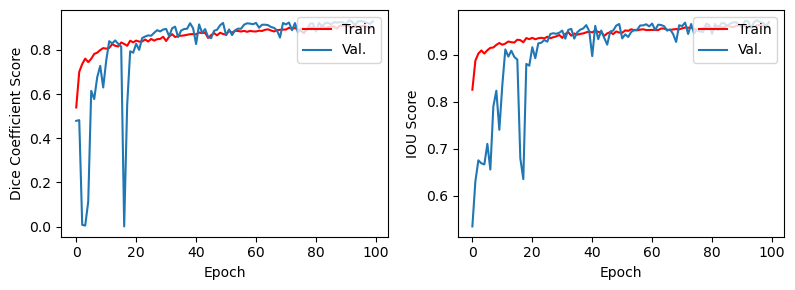

In [36]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(hist.history['dice_coe'], color='r')
plt.plot(hist.history['val_dice_coe'])
plt.ylabel('Dice Coefficient Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val.'], loc='upper right')

plt.subplot(1,3,2)
plt.plot(hist.history['iou'], color='r')
plt.plot(hist.history['val_iou'])
plt.ylabel('IOU Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val.'], loc='upper right')

plt.tight_layout()

plt.show()

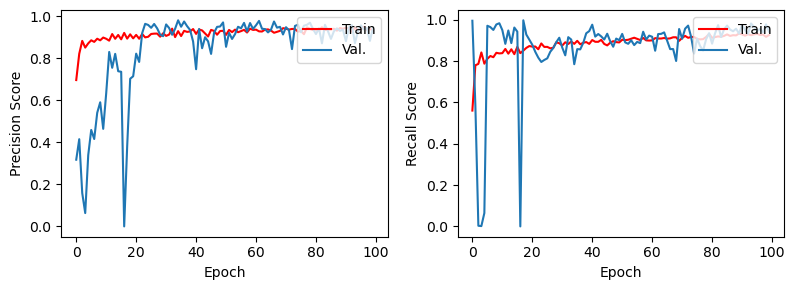

In [37]:
plt.figure(figsize=(12,3))
plt.subplot(1,3,1)
plt.plot(hist.history['precision'], color='r')
plt.plot(hist.history['val_precision'])
plt.ylabel('Precision Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val.'], loc='upper right')

plt.subplot(1,3,2)
plt.plot(hist.history['recall'], color='r')
plt.plot(hist.history['val_recall'])
plt.ylabel('Recall Score')
plt.xlabel('Epoch')
plt.legend(['Train', 'Val.'], loc='upper right')

plt.tight_layout()

plt.show()

1/1 [==============================] - 0s 440ms/step


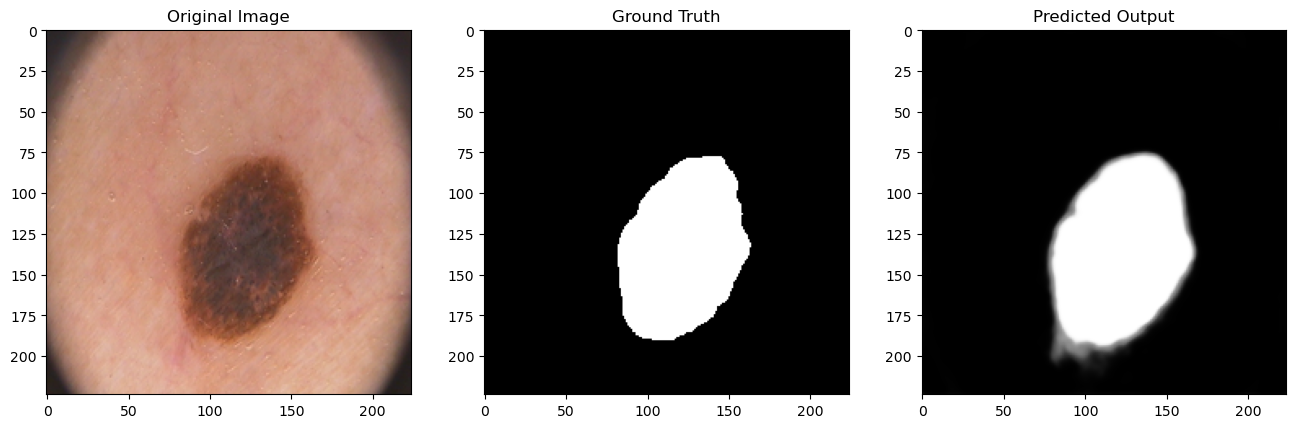

In [38]:
img_num = 49
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 139ms/step


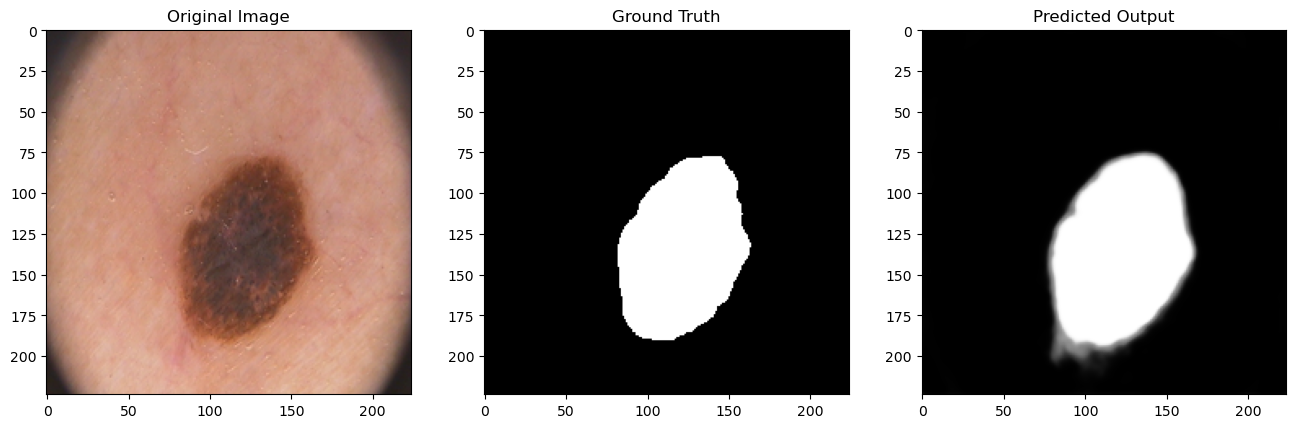

In [39]:
img_num = 49
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 163ms/step


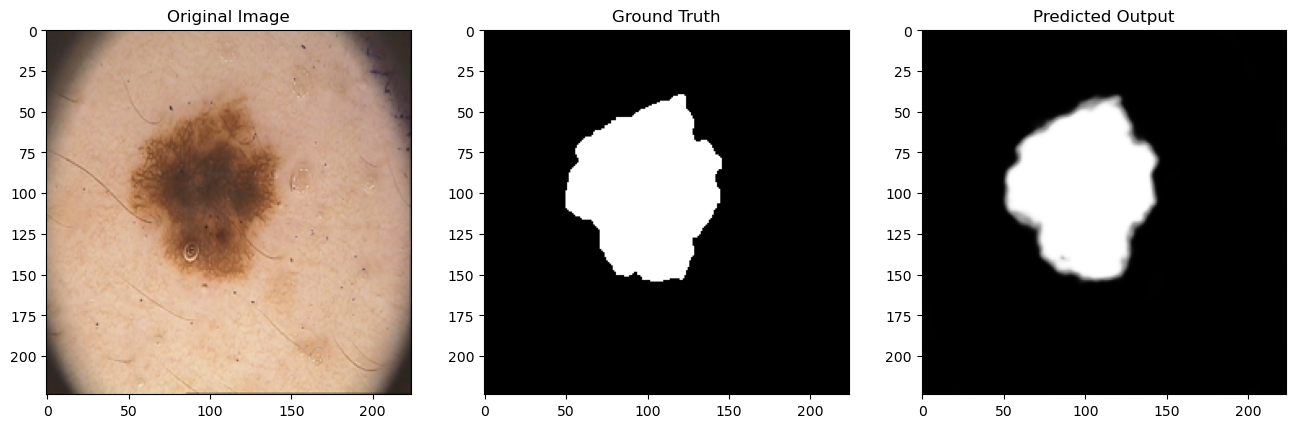

In [40]:
img_num = 10
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 127ms/step


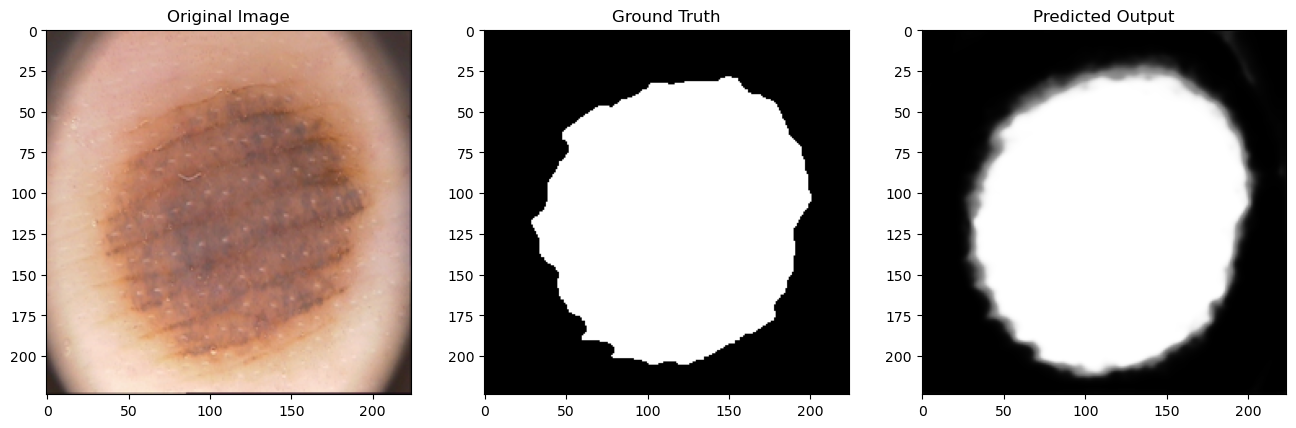

In [41]:
img_num = 36
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 127ms/step


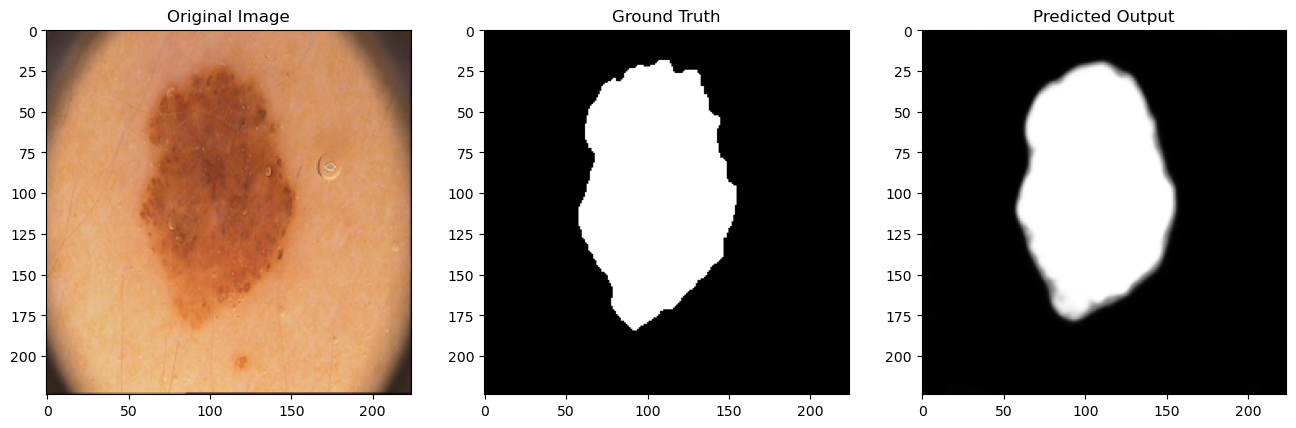

In [42]:
img_num = 32
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 134ms/step


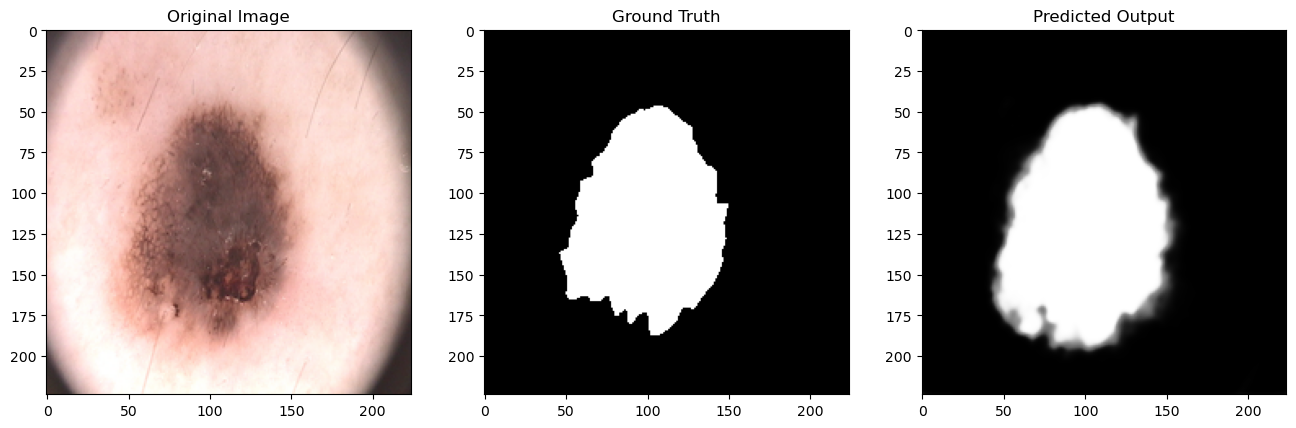

In [43]:
img_num = 29
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

1/1 [==============================] - 0s 136ms/step


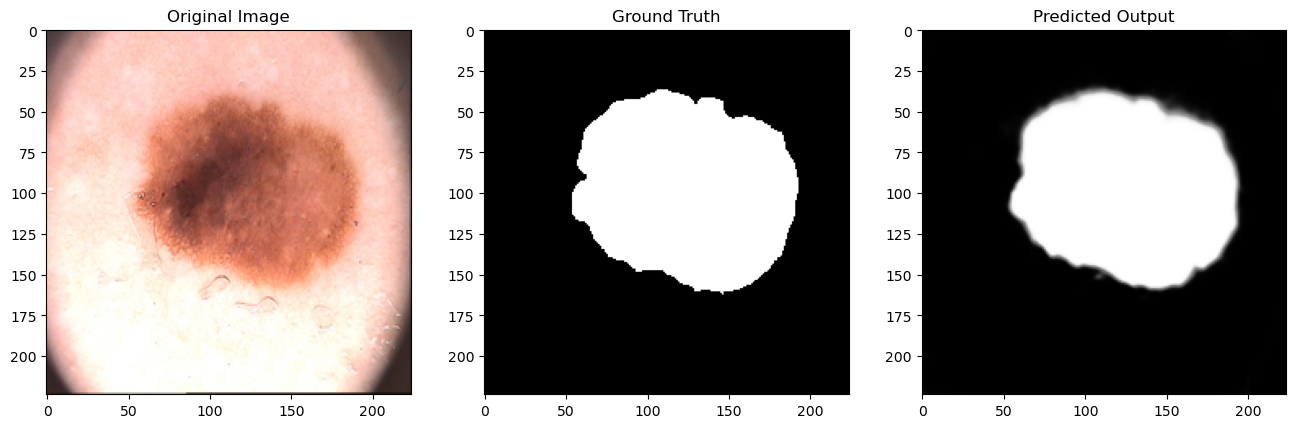

In [44]:
img_num = 21
img_pred = model_1.predict(x_test[img_num].reshape(1,224,224,3))
plt.figure(figsize=(16,16))
plt.subplot(1,3,1)
plt.imshow(x_test[img_num])
plt.title('Original Image')
plt.subplot(1,3,2)
plt.imshow(y_test[img_num], plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(1,3,3)
plt.imshow(img_pred.reshape(224,224), plt.cm.binary_r)
plt.title('Predicted Output')
plt.show()

In [45]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,224,224,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub



1/1 [==============================] - 0s 117ms/step


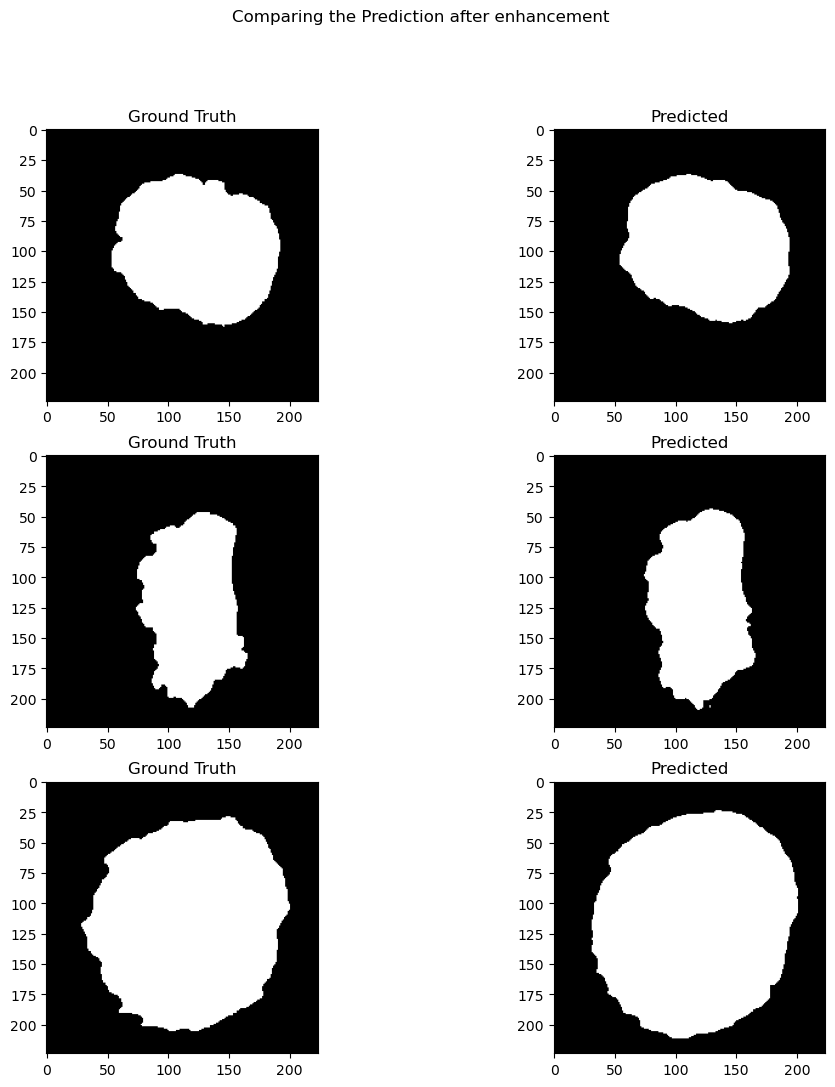

In [46]:
plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

1/1 [==============================] - 0s 426ms/step


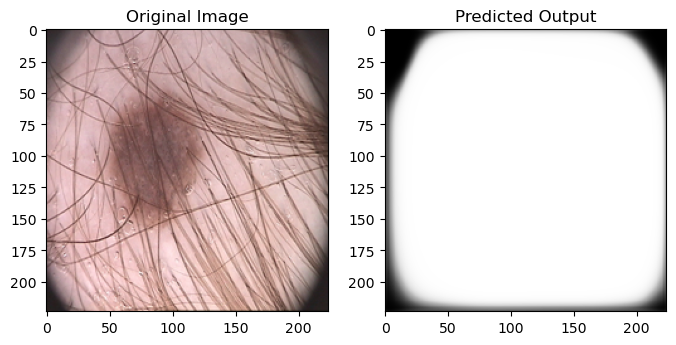

In [47]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def segment_image(image_path, model):
    img = Image.open(image_path).convert('RGB')  
    img = img.resize((224, 224))  
    img_array = np.array(img)
    img_array = img_array / 255.0 
    img_pred = model.predict(img_array.reshape(1, 224, 224, 3))
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
    plt.title('Predicted Output')
    plt.show()

image_path = '/home/mostafatarek/Desktop/000my/study/000/Skin/PH2/PH2-DatasetKaggle/trainx/IMD003.bmp' 
segment_image(image_path, model_1)


1/1 [==============================] - 0s 142ms/step


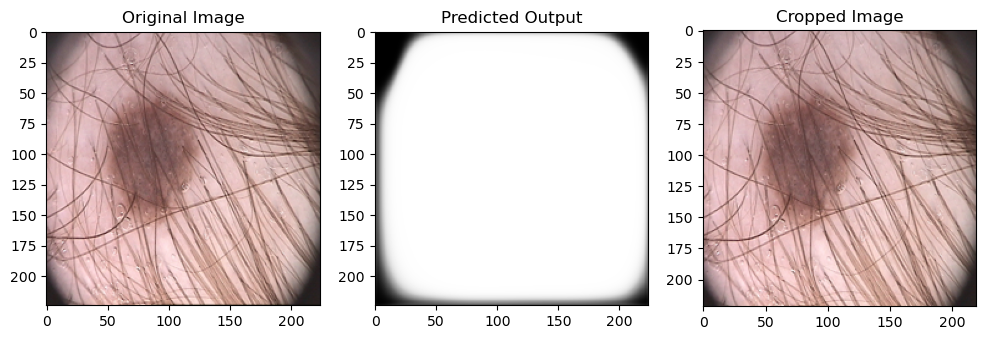

In [49]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def segment_image(image_path, model):
    img = Image.open(image_path).convert('RGB') 
    img = img.resize((224, 224)) 
    img_array = np.array(img)
    img_array = img_array / 255.0  
    
    img_pred = model.predict(img_array.reshape(1, 224, 224, 3))
    
    binary_mask = img_pred.reshape(224, 224) > 0.5
    
    segmented_area = np.where(binary_mask)
    min_y, min_x = np.min(segmented_area, axis=1)
    max_y, max_x = np.max(segmented_area, axis=1)
    cropped_img = img.crop((min_x, min_y, max_x, max_y))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
    plt.title('Predicted Output')
    plt.subplot(1, 3, 3)
    plt.imshow(cropped_img)
    plt.title('Cropped Image')
    plt.show()

image_path = '/home/mostafatarek/Desktop/000my/study/000/Skin/PH2/PH2-DatasetKaggle/trainx/IMD003.bmp'  
segment_image(image_path, model_1)


1/1 [==============================] - 0s 131ms/step


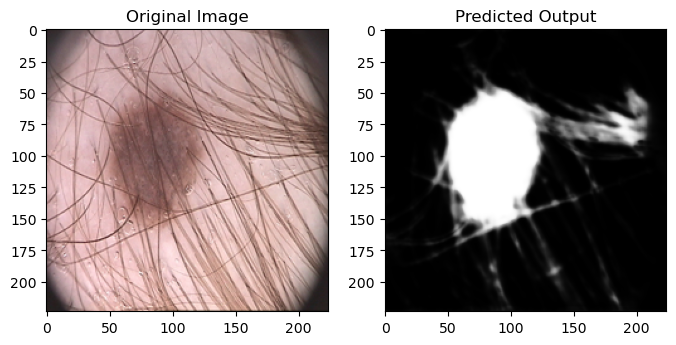

In [50]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def segment_image(image_path, model):
    img = Image.open(image_path).convert('RGB') 
    img = img.resize((224, 224)) 
    img_array = np.array(img)
    
    img_pred = model.predict(img_array.reshape(1, 224, 224, 3))
    
    plt.figure(figsize=(8, 4))
    plt.subplot(1, 2, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(1, 2, 2)
    plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
    plt.title('Predicted Output')
    plt.show()

image_path = '/home/mostafatarek/Desktop/000my/study/000/Skin/PH2/PH2-DatasetKaggle/trainx/IMD003.bmp'  
segment_image(image_path, model_1)


1/1 [==============================] - 0s 128ms/step


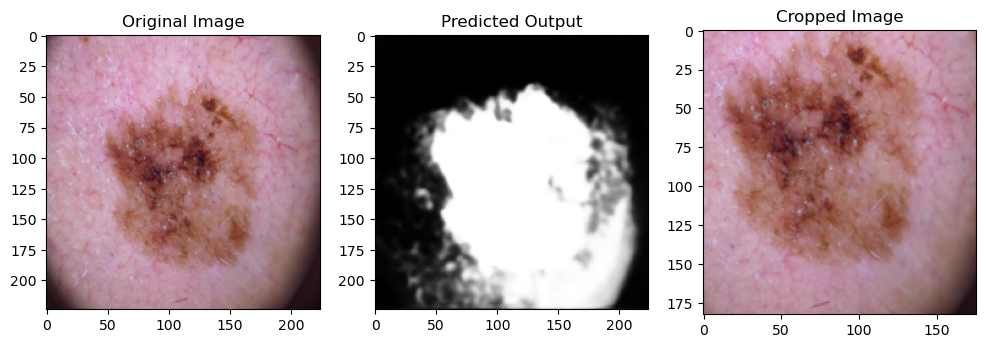

In [60]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def segment_image(image_path, model):
    img = Image.open(image_path).convert('RGB')  
    img = img.resize((224, 224)) 
    img_array = np.array(img)
    
    img_pred = model.predict(img_array.reshape(1, 224, 224, 3))
    
    binary_mask = img_pred.reshape(224, 224) > 0.5
    
    segmented_area = np.where(binary_mask)
    min_y, min_x = np.min(segmented_area, axis=1)
    max_y, max_x = np.max(segmented_area, axis=1)
    cropped_img = img.crop((min_x, min_y, max_x, max_y))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
    plt.title('Predicted Output')
    plt.subplot(1, 3, 3)
    plt.imshow(cropped_img)
    plt.title('Cropped Image')
    plt.show()

image_path = '/home/mostafatarek/Desktop/000my/study/000/Skin/HAM10000/prog/ISIC_0028900.jpg'  
segment_image(image_path, model_1)


In [ ]:
def enhance(img):
    sub = (model_1.predict(img.reshape(1,224,224,3))).flatten()

    for i in range(len(sub)):
        if sub[i] > 0.5:
            sub[i] = 1
        else:
            sub[i] = 0
    return sub

plt.figure(figsize=(12,12))
plt.suptitle('Comparing the Prediction after enhancement')
plt.subplot(3,2,1)
plt.imshow(y_test[21],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,2)
plt.imshow(enhance(x_test[21]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,3)
plt.imshow(y_test[47],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,4)
plt.imshow(enhance(x_test[47]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.subplot(3,2,5)
plt.imshow(y_test[36],plt.cm.binary_r)
plt.title('Ground Truth')
plt.subplot(3,2,6)
plt.imshow(enhance(x_test[36]).reshape(224,224), plt.cm.binary_r)
plt.title('Predicted')
plt.show()

1/1 [==============================] - 0s 145ms/step


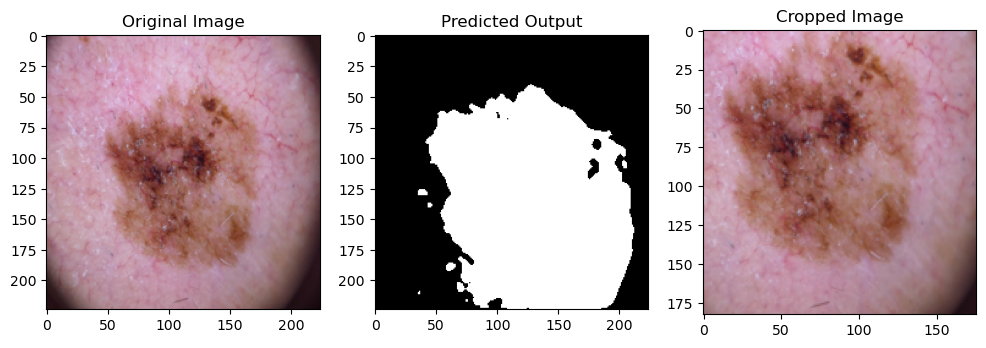

In [59]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

def segment_image(image_path, model):
    img = Image.open(image_path).convert('RGB')
    img = img.resize((224, 224))  
    img_array = np.array(img)
    
    img_pred = enhance(img_array.reshape(1, 224, 224, 3))
    binary_mask = img_pred.reshape(224, 224) > 0.5
    
    segmented_area = np.where(binary_mask)
    min_y, min_x = np.min(segmented_area, axis=1)
    max_y, max_x = np.max(segmented_area, axis=1)
    cropped_img = img.crop((min_x, min_y, max_x, max_y))
    
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 3, 1)
    plt.imshow(img)
    plt.title('Original Image')
    plt.subplot(1, 3, 2)
    plt.imshow(img_pred.reshape(224, 224), plt.cm.binary_r)
    plt.title('Predicted Output')
    plt.subplot(1, 3, 3)
    plt.imshow(cropped_img)
    plt.title('Cropped Image')
    plt.show()

image_path = '/home/mostafatarek/Desktop/000my/study/000/Skin/HAM10000/prog/ISIC_0028900.jpg'  
segment_image(image_path, model_1)
